In [10]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# normalizing flows

#start with a base distribution 1d
base_dist = torch.distributions.normal.Normal(0,1)

#target distribution
target = torch.distributions.Normal(2.0, 0.5)

In [ ]:
# start with the transformation for a simple case assume T(x) = a + bx

class Transformation(nn.Module):
  def __init__(self):
    super().__init__()
    self.a = nn.Parameter(torch.randn(1))
    self.b = nn.Parameter(torch.randn(1))

  def forward(self, x):
    #return the value and log det of jacobian
    return self.a + self.b * x, torch.log(torch.abs(self.b))

  def inverse(self, x):
        z = (x - self.a) / self.b
        log_det = -torch.log(torch.abs(self.b))
        return z, log_det


class MultiTransformation(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.flows = nn.ModuleList([Transformation() for _ in range(n)])

    def forward(self, x):
        log_det = torch.zeros_like(x)
        for flow in self.flows:
            x, ld = flow(x)
            log_det += ld
        return x, log_det

    def inverse(self, x):
        log_det = torch.zeros_like(x)
        for flow in reversed(self.flows):
            x, ld = flow.inverse(x)
            log_det += ld
        return x, log_det


class NormalizingFlows(nn.Module):
    def __init__(self, num_flows):
        super().__init__()
        self.flow_chain = MultiTransformation(num_flows)
        self.base_dist = torch.distributions.Normal(0., 1.)

    def log_prob(self, x):
        # Compute inverse pass to get z and total log-det
        z, log_det = self.flow_chain.inverse(x)
        log_pz = self.base_dist.log_prob(z)
        # Return mean log-likelihood over the batch
        return (log_pz + log_det).mean()

    def sample(self, num_samples):
        # Sample from base distribution and push through flows
        z0 = self.base_dist.sample((num_samples,))
        x, _ = self.flow_chain(z0)
        return x


In [ ]:
target_dist = torch.distributions.Normal(2.0, 0.5)

model = NormalizingFlows(3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
x_data = target_dist.sample((10000,))
for epoch in range(20_000):
    optimizer.zero_grad()
    loss = -model.log_prob(x_data)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")



Streaming output truncated to the last 5000 lines.
Epoch 15001, Loss: 0.7126
Epoch 15002, Loss: 0.7126
Epoch 15003, Loss: 0.7126
Epoch 15004, Loss: 0.7126
Epoch 15005, Loss: 0.7126
Epoch 15006, Loss: 0.7126
Epoch 15007, Loss: 0.7126
Epoch 15008, Loss: 0.7126
Epoch 15009, Loss: 0.7126
Epoch 15010, Loss: 0.7126
Epoch 15011, Loss: 0.7126
Epoch 15012, Loss: 0.7126
Epoch 15013, Loss: 0.7126
Epoch 15014, Loss: 0.7126
Epoch 15015, Loss: 0.7126
Epoch 15016, Loss: 0.7126
Epoch 15017, Loss: 0.7126
Epoch 15018, Loss: 0.7126
Epoch 15019, Loss: 0.7126
Epoch 15020, Loss: 0.7126
Epoch 15021, Loss: 0.7126
Epoch 15022, Loss: 0.7126
Epoch 15023, Loss: 0.7126
Epoch 15024, Loss: 0.7126
Epoch 15025, Loss: 0.7126
Epoch 15026, Loss: 0.7126
Epoch 15027, Loss: 0.7126
Epoch 15028, Loss: 0.7126
Epoch 15029, Loss: 0.7126
Epoch 15030, Loss: 0.7126
Epoch 15031, Loss: 0.7126
Epoch 15032, Loss: 0.7126
Epoch 15033, Loss: 0.7126
Epoch 15034, Loss: 0.7126
Epoch 15035, Loss: 0.7126
Epoch 15036, Loss: 0.7126
Epoch 15037, 

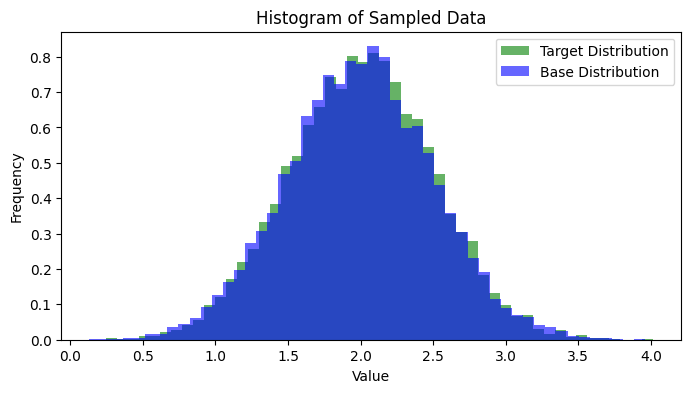

In [ ]:

import numpy as np
import torch

# Sample data from the target distribution
target_dist = model
sampled_target_data = target_dist.sample(10000).detach().numpy()

base_dist = torch.distributions.normal.Normal(2,0.5)
sampled_base_data = base_dist.sample((10000,)).numpy()


# Plot a histogram
plt.figure(figsize=(8, 4))
plt.hist(sampled_target_data, bins=50, density=True, alpha=0.6, color='g', label='Target Distribution')
plt.hist(sampled_base_data, bins=50, density=True, alpha=0.6, color='b', label='Base Distribution')
plt.title('Histogram of Sampled Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.show()

# RealNVP

In [43]:
class CouplingLayer(nn.Module):
    def __init__(self, mask, input_dim, hidden_dim, num_hidden):
        super().__init__()
        self.register_buffer('mask', mask)
        self.input_indices = (mask == 1).nonzero(as_tuple=True)[0]
        self.output_indices = (mask == 0).nonzero(as_tuple=True)[0]
        self.in_features = self.input_indices.sum().item()
        self.out_features = self.output_indices.sum().item()

        def build_net():
            layers = [nn.Linear(self.in_features, hidden_dim), nn.ReLU()]
            for _ in range(num_hidden):
                layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
            layers.append(nn.Linear(hidden_dim, self.out_features))
            return nn.Sequential(*layers)

        self.s_net = build_net()
        self.t_net = build_net()

    def forward(self, x):
        x1 = x[:, self.input_indices]
        x2 = x[:, self.output_indices]

        s = self.s_net(x1)
        t = self.t_net(x1)

        y2 = x2 * torch.exp(s) + t
        y = x.clone()
        y[:, self.output_indices] = y2

        log_det = torch.sum(s, dim=1)
        return y, log_det

    def inverse(self, y):
        y1 = y[:, self.input_indices]
        y2 = y[:, self.output_indices]

        s = self.s_net(y1)
        t = self.t_net(y1)

        x2 = (y2 - t) * torch.exp(-s)
        x = y.clone()
        x[:, self.output_indices] = x2

        log_det = -torch.sum(s, dim=1)
        return x, log_det


In [44]:
class RealNVP(nn.Module):
    def __init__(self, num_coupling_layers, input_dim, hidden_dim, num_hidden):
        super().__init__()
        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        for i in range(num_coupling_layers):
            mask = self._create_mask(i)
            self.layers.append(CouplingLayer(mask, input_dim, hidden_dim, num_hidden))

    def _create_mask(self, i):
        mask = torch.zeros(self.input_dim)
        mask[i%2::2] = 1
        return mask

    def forward(self, x):
        log_det = torch.zeros(x.shape[0])
        for layer in self.layers:
            x, ld = layer(x)
            log_det += ld
        return x, log_det

    def inverse(self, z):
        log_det = torch.zeros(z.shape[0])
        for layer in reversed(self.layers):
            z, ld = layer.inverse(z)
            log_det += ld
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.forward(x)
        log_pz = -0.5 * torch.sum(z**2, dim=1) - 0.5 * x.shape[1] * torch.log(torch.tensor(2 * torch.pi))
        return log_pz + log_det

In [36]:
# init the dataset using make_moons
from sklearn.datasets import make_moons, make_s_curve
X, _ = make_s_curve(n_samples=10_000, noise=0.1, random_state=42)

In [37]:
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker
def plot_3d(points, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


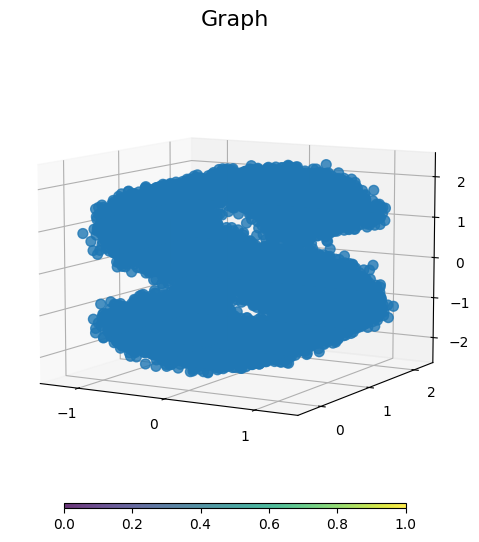

In [38]:
plot_3d(X, "Graph")

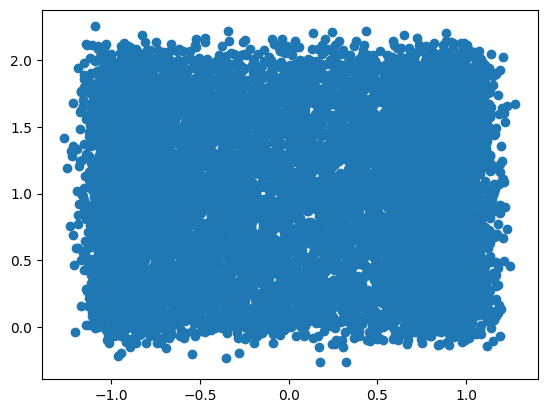

In [39]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1])

In [40]:
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [45]:
# training loop

model = RealNVP(6, 3, 128, 2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30

for epoch in range(n_epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        log_likelihood = model.log_prob(x_batch)
        loss = -log_likelihood.mean()  # maximize likelihood = minimize negative log-likelihood
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/30, Loss: 3.5195
Epoch 2/30, Loss: 3.1370
Epoch 3/30, Loss: 2.9428
Epoch 4/30, Loss: 2.7230
Epoch 5/30, Loss: 2.6159
Epoch 6/30, Loss: 2.5391
Epoch 7/30, Loss: 2.4905
Epoch 8/30, Loss: 2.4851
Epoch 9/30, Loss: 2.4805
Epoch 10/30, Loss: 2.4833
Epoch 11/30, Loss: 2.4395
Epoch 12/30, Loss: 2.4060
Epoch 13/30, Loss: 2.4170
Epoch 14/30, Loss: 2.3977
Epoch 15/30, Loss: 2.3771
Epoch 16/30, Loss: 2.3707
Epoch 17/30, Loss: 2.3864
Epoch 18/30, Loss: 2.3582
Epoch 19/30, Loss: 2.3630
Epoch 20/30, Loss: 2.3345
Epoch 21/30, Loss: 2.3380
Epoch 22/30, Loss: 2.3229
Epoch 23/30, Loss: 2.3381
Epoch 24/30, Loss: 2.3249
Epoch 25/30, Loss: 2.3386
Epoch 26/30, Loss: 2.3150
Epoch 27/30, Loss: 2.3227
Epoch 28/30, Loss: 2.3187
Epoch 29/30, Loss: 2.3334
Epoch 30/30, Loss: 2.3152


In [32]:
# sample from the model
def sample(model, num_samples):
    with torch.no_grad():
        z = torch.randn(num_samples, 3)
        x, _ = model.inverse(z)
    return x.numpy()


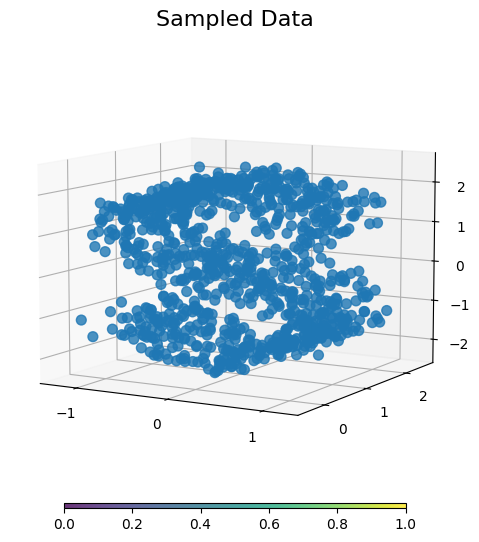

In [33]:
sampled_data = sample(model, 1000)

plot_3d(sampled_data, "Sampled Data")